# Report

# Group project for *Advanced topics in machine learning* lecture (2019)
### Benjamin Ellenberger, Nicolas Deperrois, Laura Kriener

## Chosen Topic: **Music generation**

### Motivation and State-of-the-Art

The topics for the group project work was chosen in the very beginning of the course.
As it was announced that the course will nearly always use images for demonstrations, examples and excercises, we decided that our project should be on a different form of data.
We decided to work in the broad field of music generation with deep learing.

To narrow down the topic we investigated what the state of the art in this field is.
The most impressive recent results are produced by Google and OpenAI.
The [Google Magenta project](https://magenta.tensorflow.org/) covers a wide range of applications such as harmonization, drum-machines and a music generating network using the transformer network architecture with attention.

An other very recent result in the field of generating music was published by OpenAI. The [MuseNet](https://openai.com/blog/musenet/) uses the recently published GPT2-architecture which is a large-scale transformer network as well. 

The Google and OpenAI approaches as well as other (less famous) approaches have in common, that they employ very complicated network architectures in combination with the use of immense computational resources.

As the required computational power is far out of our reach, we wondered if this level of complexity is really unavoidable.
And so the question **How much can you do with how little?** became the leading theme for our project.
We want to see, what results can be achieved using much simpler network architecutres (i.e. architectures within the scope of the lecture)?
Which aspects of music generation can be achieved and which have to be ignored? For example can you generate a resonable melody line without considering the rhythm?

### Challenges
The main challenge is that music generation is a very broad topic. Before we can even start we have to answer a couple of questions:

- What exactly do we want to generate? Melody? Rhythm? Harmony?

This will depend on the network structures we try out. For example for simple feed-forward networks we only focus on melody, while we include rhythm in the LSTMs.

- How to feed music into a network? Spectrum? Pitches? Intervals?

We will not use spectrum or audio-data, instead we will work with pitches and intervals and note-lengths extracted from midi-files.

- What kind of music?

As we try to keep things as simple as possible, we decided to use the widely used bach chorale data-set (see `data/raw/bach`).

- How do we evaluate the result?

Music and the quality of music is a highly subjective topic. It is very difficult to find a metric that evaluates how good a produced piece of music is.
We plan to evaluate the pieces of music produced by the different network architectures by comparison and by the networks ability to capture different aspects of music (e.g. if one architecture can only produce melodies without considering rhythm and the other includes rhythm the second one is better suited for music generation). Additionally a measure for quality can be the similarity to the music style it was trained on. 

### Data sets

We will work on the Bach chorale dataset which we included in the repository (see `data/raw/bach`).
Midi-files are binary, therefore it is difficult to modify and create them directly.
We are using the python libaries `pianoroll` and `midicsv` which translates a midi-file into a human-readable (and modifiable) csv-string.
From this we have written our own utility functions that allow us to extract high-level information about the music (e.g. tempo, tonality) and perform changes to the tracks and write them back to a midi file. The utility functions are located in the file `src/midi_utils.py`. A demonstration on how to use them can be found in the notebook `demo_midi_utils.ipynb`. The functions to create a Pytorch compatible dataset from the midi-data are in the file `src/dataset_utils.py`.

******
*****

# **Feed-Forward Networks**

Starting from the simplest possible network architecture, we will first investigate the potential and limitations of feed-forward networks.
Their architecture is not really suited to deal with time-series data, because one input sample is presented as a whole and at the same time to the network.
Also there is no mechanism for memory of the past.
Respecting these limitations, we simplify the task of "music generation" to **predicting the next note in a melody given the $n$ previous notes** (we only predict the pitch not the length of notes).

### Generation mechanism

This setup also allows for a generation mechanism for a longer melody as sketched in the figure below:
We start the network of with a set of notes from a melody ($n1$ to $n10$) as input. 
The network then predicts the next note for the melody ($n11$). In the next step we give the network a new set of input which consists of the notes $n2$ to $n10$ **and** the note it predicted before $n11$. The network now predicts the twelth note ($n12$) which is then used in the input for the next round.

The main goal of this generation task is to produce a series of notes which is not dissonant and stays in the tonality of the given starter notes.


![Schematic drawing of generation procedure](graphics/forward3.png)


### Network structure

The figure below shows a sketch of the feed-forward architecture that produced the best results.
Note that the inputs for the network are not the pitches of the starter-notes but the intervals between them.
This is beneficial, as using the intervals automatically provides a form of normalization.
The use of intervals for example removes for example the dependence on the key the melody is written in.
For example the line C-D-E-F (C-Major) will produce `[2, 2, 2, 1]` (counting the intervals in half-tone steps).
Even though the line D-E-F#-G (D-Major) is in a different key, it will produce the same intervals `[2, 2, 2, 1]`.

The input layer of the network contains 10 units, each coding for one of the ten starter-intervals.
The input is connected to two hidden layer with 128 units each.
The output layer has 25 units. Each is coding for one possible interval (step-size: half-tones) in the range of $\pm$ 1 Octave.
We train the network by presenting it with 10-intervals pieces of the bach dataset and let it predict the 11th interval.
The loss is calculated using the CrossEntropyLoss-function in pyTorch.
In early experiments the output layer contained only one unit which was used to predict the pitch/interval value. 
The results were much worse compared to predicting the probability for each possible interval. 
In the generation mode of the network the interval with the highest probability is picked as the "chosen interval" by the network.

![Feed-forward architecture](graphics/forward2.png)

### Results

![Feed-forward architecture](graphics/loss_forward_intervals.png)

The figure above shows the training process of the described network architecture.
We see a clear occurance of overfitting, as the loss on the validation dataset first plateaus and then increases while the loss on the training data continues to decrease.
The 3 stars in the plot mark where snapshots of the network model were taken during training and saved for the generation of melodies.
The notebook cells below show an exemplary melody generated by an untrained network, by the network at the end of the plateau in the validation loss and at the end of training, when the validation loss has already increased again.
For the generation of the audio samples below the same 10 starter-notes were used.
They are included in the audio file.


#### **Alternative architectures / training methods and their impact**
In the following we quickly describe some different variations of the described network architecture and why they were dismissed in favor of the one presented above.

- more neurons/layers: lead to worse overfitting without increasing performance significantly
- less neurons/layers: delay the overfitting but decrease performance
- regularization methods: only delay overfitting while decreasing performance
- more starter-notes (i.e. larger input layer): worse overfitting
- less starter-notes (everything below 10): decreases overfitting but during generation the network will just produce a repeated loop of the starter-notes


#### Audio sample of untrained network
We had to stop the generation of this melody early because the notes predicted by the network drifted out of the available range in midi-files.
The untrained network clearly does not stay in a fairly small pitch range (as Bach melodies usually do) and produces lines that sound unharmonic.

In [1]:
import pygame

filename = 'results/feedforward_net_track_intervals_untrained.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
pygame.mixer.music.stop()

#### Audio sample of the network at the end of training
The melody produced by this network stays within a reasonable pitch range of the starter notes.
It produces a harmonic sounding line of notes and seems to stay within the tonality of the starter notes.

In [3]:
import pygame

filename = 'results/feedforward_net_track_intervals.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [4]:
pygame.mixer.music.stop()

#### Audio sample of network before severe overfitting
The melody produced by this network stays within a reasonable pitch range of the starter notes.
It produces a mostly harmonic sounding line of notes and mostly seems to stay within the tonality of the starter notes.
There are some questionable choices of notes in the melody

In [6]:
import pygame

filename = 'results/feedforward_net_track_intervals_snapshot.mid'
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [7]:
pygame.mixer.music.stop()

#### Discussion of results
Bearing in mind that we chose the feed-forward architecture as the most simple model, we can be content with the result. 
It was clear from the start that the feed-forward networks would only be able to learn a very restricted task, i.e. no rhythm and chords.
Therefore we chose only to try to learn to produce short melody patches. This we were able to achieve.
The overfitting which occured is a problem, that might be alieviated by a larger dataset. However, the larger sets available do contain different styles of music than Bach chorales which we deliberatly chose for their simple melody lines.

We see that both trained snapshots of the network produce a melody that stays within a reasonable range of notes and does not drift off like the untrained version.
Also they produce lines of notes that are consistent with the harmony style by Bach and they mostly stay within the tonality.

One could argue that using the network which was trained with heavy overfitting is ok for music generation (but not for predicting the next note of a melody line), because it effectively does what a human composer does: It "knows" short patches of melody from the training set (i.e. the music it already knows) and reuses parts of these melody patches to generate new melodies. Human composes do this as well (a lot). For example, someone who knows a couple of Hans Zimmer movie soundtracks will very quickly recognize if a new soundtrack is written by Hans Zimmer, because he very often reuses certain themes and instrumentation schemes.

### Exemplary usage of the code
#### Training the network model and generating with it

In [1]:
import os
import copy
import torch
import src.feed_forward_utils as ff
import matplotlib.pyplot as plt
%matplotlib inline

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
os.chdir(home_dir)

data_dir = '/data/raw/bach'

minibatch_size = 32
train_valid_ratio = 0.8        # size ratio of the train- and validation dataset
feature_qty = 10               # how many starter-intervals are presented to network
prediction_qty = 1             # must be one if intervals are used
interval_range = [-12, 12]     # in halftones -> 1 octave
snapshot_epoch = 50            # epoch at which a snapshot of the model is created during training
n_epochs = 100
learning_rate = 0.001
hidden_size = 128

tracks = ff.load_tracks(data_dir, 1)
train_set, valid_set, train_loader, valid_loader = ff.generate_dataloaders(tracks, minibatch_size, train_valid_ratio, 
                                                                           feature_qty, prediction_qty, interval_range)
input_size = len(train_set[0][0])   # get input size
input_example = train_set[0][0]
output_size = len(range(interval_range[0], interval_range[1]+1, 1))     # get output size
output_example = train_set[0][1]
print("Training set size", len(train_set))
print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example (idx of next interval) {}".format(output_example))

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
Loaded 357 tracks
Mean of the dataset: 0.00045936931473620525
Number of samples: 16490
Training set size 13192
Input size 10/ output size 25/ learning rate 0.001
Input example tensor([ 0.0833, -0.0833,  0.0000,  0.2500,  0.1667, -0.4167,  0.2500, -0.2500,
        -0.1667, -0.1667])
Output example (idx of next interval) 11


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
forward_model = ff.FeedForward(input_size, hidden_size, output_size)
untrained_model = copy.deepcopy(forward_model)
untrained_model = untrained_model.to(device)
forward_model = forward_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forward_model.parameters(), lr=learning_rate)

In [3]:
train_losses, val_losses, snapshot_model = ff.train(forward_model, train_loader, valid_loader, 
                                                    optimizer, n_epochs, criterion, device=device, 
                                                    verbose=True, snapshot=snapshot_epoch)

Epoch 1/100: train_loss: 2.1294, val_loss: 2.0678
Epoch 11/100: train_loss: 1.7138, val_loss: 1.7446
Epoch 21/100: train_loss: 1.5794, val_loss: 1.6745
Epoch 31/100: train_loss: 1.4539, val_loss: 1.6746
Epoch 41/100: train_loss: 1.3429, val_loss: 1.6383
Epoch 51/100: train_loss: 1.2459, val_loss: 1.6625
Epoch 61/100: train_loss: 1.1526, val_loss: 1.7490
Epoch 71/100: train_loss: 1.0693, val_loss: 1.7028
Epoch 81/100: train_loss: 0.9934, val_loss: 1.7854
Epoch 91/100: train_loss: 0.9268, val_loss: 1.8062


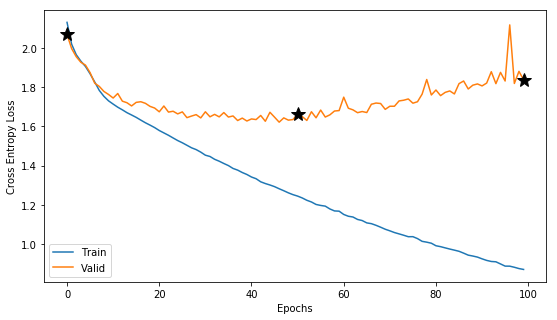

In [4]:
os.chdir(home_dir)
result_dir = home_dir + '/results/'
result_name = 'retrained_feedforward_'
ff.save_results(result_dir, result_name, untrained_model, snapshot_model, 
                forward_model, train_losses, val_losses, snapshot_epoch)

In [15]:
sample_idx = 45
predict_length = 30

filename_untrained = result_dir + result_name + 'untrained.mid'
ff.generate_melody(device, valid_set, sample_idx, untrained_model, predict_length, interval_range, filename_untrained)

filename_snapshot = result_dir + result_name + 'snapshot.mid'
ff.generate_melody(device, valid_set, sample_idx, snapshot_model, predict_length, interval_range, filename_snapshot)

filename_trained = result_dir + result_name + 'trained.mid'
ff.generate_melody(device, valid_set, sample_idx, forward_model, predict_length, interval_range, filename_trained)

In [16]:
import pygame

filename = filename_trained # or filename_trained or filename_snapshot
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [17]:
pygame.mixer.music.stop()

### Loading the pretrained model and generating with it

In [18]:
import os
import torch
import src.feed_forward_utils as ff

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
os.chdir(home_dir)

data_dir = '/data/raw/bach'

minibatch_size = 32
train_valid_ratio = 0.8        # size ratio of the train- and validation dataset
feature_qty = 10               # how many starter-intervals are presented to network
prediction_qty = 1             # must be one if intervals are used
interval_range = [-12, 12]     # in halftones -> 1 octave
snapshot_epoch = 50            # epoch at which a snapshot of the model is created during training

tracks = ff.load_tracks(data_dir, 1)
train_set, valid_set, train_loader, valid_loader = ff.generate_dataloaders(tracks, minibatch_size, train_valid_ratio, 
                                                                           feature_qty, prediction_qty, interval_range)

Loaded 357 tracks
Mean of the dataset: 0.00045936931473620525
Number of samples: 16490


In [26]:
os.chdir(home_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_filename = 'results/feedforward_trained.pth'
model_loaded = torch.load(model_filename)
model_loaded.to(device)
model_loaded.eval()

sample_idx = 42
predict_length = 25
result_dir = 'results/'
result_name = 'loaded_feedforward_'
filename_loaded = result_dir + result_name + 'generating.mid'
ff.generate_melody(device, valid_set, sample_idx, model_loaded, predict_length, interval_range, filename_loaded)

In [27]:
import pygame

pygame.init()
pygame.mixer.music.load(filename_loaded)
pygame.mixer.music.play()

In [28]:
pygame.mixer.music.stop()

*********
*********

# **LSTMs** - including rhythms and generate harmonization 

In this part, we will try to generate melodies from the same dataset (Bach Chorals) using recurrent neural networks (RNN) with long short term memory units (LSTM) as in the tutorial 08 of the class, based on the two following blog posts:

- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c

The idea would be to extend the character-to-character LSTM network to midi files. We will use another representation of the data, named 'pianorolls', where a single melody is stored in an array containing the melody pitches across time. This is one of the most frequent representations used, although it has some limitations. For instance, there is no way to differentiate between a long note (1 half-note) and 4 short-ones (4 eight-notes). However, it brings a considerable advantage compared to the previous used representations as it can store rhythm and silences, depending on the chosen time-step. 

Moreover, each possible note is considered as a distinct element of a vocabulary. We will then use $N$ input nodes, where $N$ is the size of the vocabulary (i.e., the number of distinct notes, including silences). 
Thus, these pianorolls arrays will be converted into one-hot vectors containing the corresponding pitch (or silence, represented by 0) for each time step, and will be fed to the RNN network defined below. 

All methods for this part are stored in the python module `src.RNN_utils`

## Generating a single melody with LSTMs

### Data representation
We use the pypianoroll library - https://salu133445.github.io/pypianoroll/ - to convert a midi file into a multitrack object, get the soprano track, transpose it to C major, create a new multitrack object out of it, and finally write it to a new midi file. 
We first import midi files, choose a voice, and concatenate all melodies into a big sequence of notes. We also calculate the pitch ranges. In order to minimize the size of one-hot encode vectors, we restrict the pitches to values next to 0, using the minimum pitch found in the dataset. 

### Network structure: LSTM network as for note-to-note melody generation
We now build a network to implement note-to-note melody generation using LSTMs units **without** drop-out of the output. This network is highly inspired from the Tutorial 08 of the class, by replacing characters by notes. 

For training the model, we declare a function, where we define an optimizer (Adam) and loss (cross entropy). Then, training and validation data are separated and the hidden state of the RNN is initaliazed. Looping over the training melody batches, we use the functions `get_pianoroll_batches` and `one_hot_encode_batch` in order to build batches and feed them to the network input. This function is also adapted to harmonization that will be defined below. Every once a while, we generate some loss statistics (training loss and validation loss) to let us know if the model is training correctly.

As a first attempt to generate a melody using LSTMs with pianorolls, we will simply try to generate a single voice (soprano, alto, tenor or bass), training the network on the whole midi file dataset concatenated into a long sequence of notes all translated to the same tonality (here, C Major or its relative A minor). The later operation will particularly facilitate learning on such a small dataset as all melodies will be rescaled to the same tonality, thus preventing abrupt changes among melody batches. 

### Results 
In order to evaluate the training efficiency of the note-to-note generating task with LSTMs, we plot the evolution of training and validation losses across epochs. As in the previous section, the 3 stars in the plot represent snapshots of the LSTM model taken during training and saved for the generation of melodies. Interestingly, we can also notice a similar evolution of the validation loss, first decreasing, then platauing and finally increasing again, illustrating considerable overfitting. 
![RNN-architecture](graphics/RNN_single_plot.png)

In the cells below, we present generated melodies for the selected voice using the NoteRNN network at different stages of learning: at the beginning (random), at early-stopping (early) and at the end of learning (overfit). As in text generation, a starting sequence of 4 eighth notes is imposed to the network. 

#### Audio sample of untrained network
Let's first try melody generation with a random initial network (no training). 
As expected, it does not sound like a Bach melody, as it is totally out of any possible key. 


In [15]:
import pygame

filename = home_dir + "/results/RNN_single_random.mid"
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [16]:
pygame.mixer.music.stop()

#### Audio sample of network before severe overfitting
The melody produced by this network is quite coherent as it catches a certain tonality and respects the associated harmony, most of the time C Major, as imposed by the starting note. In addition to the feedforward case, it also includes rhythm, even if most of the time quarter and half notes are produced, while it could also generate eigth notes. 

In [17]:
filename = home_dir + "/results/RNN_single_early.mid"
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [18]:
pygame.mixer.music.stop()

#### Audio sample of network at the end of training
As in the previous case, the melody produced by the network at the end of training with severe overfitting is totally in the pitch range of the initial tonality, and rhythms choice are a bit more coherent than in the previous case. 

In [19]:
filename = home_dir + "/results/RNN_single_overfit.mid"
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [13]:
pygame.mixer.music.stop()

#### Discussion of the results 
As in the feedforward case, we obtain a typical evolution of the validation loss which triggered the interest to qualitatively evaluate the results at 3 essential stages of learning. Surprisingly, we obtain similar results than with feedforward network in terms of pitch and tonality, but using pianorolls enabled us to also generate rhythms in the melody, even if they are quite slow and do not fully respect the patterns of a Bach Choral melody.  
We can thus conclude that to perform such a single task as generating melodies, the use of the timing component from recurrent networks is not really beneficial, and should be test on more complex tasks as shown below.


## Generating harmonization with LSTMs

We observed above that it is possible to generate a coherent melody using a slightly modified version of the original character-to-character RNN. Here, we will investigate whether such a network can perform more complex task, such as harmonizing a given voice. For instance, from the soprano sequence, we would like to generate the associated alto voice. 

### Network structure: LSTM network as for note-to-note melody harmonization

In this section, we will use the same RNN network as above, with slight modifications in the learning rate, number of units and batch size. The only noticeable change is that the training process is now specialized to harmonization. Indeed, two long sequences of notes (pianorolls) are now given to the network. The input sequence, from which we want to generate harmonization (in our case, the soprano voice), and the target sequence, that we wish to generate to properly harmonize the input voice. The idea is to keep the note-to-note structure, but instead of predicting the next note a sequence, we predict the note from another voice at the same time step. 
Three networks were used to perform harmonization of the soprano voice, each corresponding to a given lower voice: alto, tenor and bass. Here again, we recorded the 3 essential learning stages and evaluate them for harmonization. 

### Results 

The figure below shows the evolution of training and validation losses across epochs for each harmonizing RNN: alto, tenor and bass. Intertingly, they show a similar shape as for melody generation, all first reaching a plateau and severely overfitting. Furthermore, it looks like training and validation losses adversarial: when the training loss increases again, the validation loss decreases. This shows that overfitting totally prevent the network from generating the original voices. 

![RNN-architecture-harm](graphics/RNN_harmonization_plot.png)

It is now time to test the quality of the RNNs trained to harmonize a soprano voice by generating separately alto, tenor and bass voices. We will test it on one given Bach midi file in the browser. 

#### Audio sample of untrained network

Let's first generate harmonization with a ramdom initial network, without training. As expected, the harmonization is totally random, thus all voices are not following the soprano melody and generate random melodies independently. 

In [63]:
filename = home_dir + "/results/RNN_harmonization_random.mid"
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [64]:
pygame.mixer.music.stop()

#### Audio sample of network before severe overfitting 
We now test the quality of harmonization on the early-stopped network. 
The obtained track sounds much better and start to harmonize the soprano voice correctly, especially by trying to match the soprano rhythm. However, it is not optimal as we cannot hear any coherent harmonies and cadences. 
Let's finally try on the highly-overfitting network. 

In [65]:
filename = home_dir + "/results/RNN_harmonization_early.mid"
pygame.init()
pygame.mixer.music.load(filename)
pygame.mixer.music.play()

In [66]:
pygame.mixer.music.stop()

#### Audio sample of network at the end of training

The overfitting networks sounds to generate voices that match much better with the soprano voice than the previous networks! Even if at the beginning, the voices are not really coherent, they start to catch some relevant melodies that vertically harmonize the soprano voice. 

In [75]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_overfit.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [76]:
pygame.mixer.music.stop()

#### Discussion of the results from the overfitting case

We hypothesize that such surprising results might be specific to music generation. Bach Chorales are quite similar, especially when transcripted to C Major (or its relative A minor), and overfitting the training set can lead to optimal network features to generate 3 voices on a soprano voice which harmonization was never learned (validation set). Even if the validation error is huge compared to the early stopping case, it does not mean that the generated voices are wrong. The overfitted network generate complete different alto/tenor/bass melodies from the original ones, which might explain this huge validation error, but these melodies vertically chords and cadences that can turn out to be really coherent!
As an example, think of the original track ending up with an interrupted cadence, in a total different tonality than C Major (let's say, A Major), which has been seen less often that a perfect cadence (C Major) in the training set. The overfitting network will unless try to recover this perfect cadence as it learned to do by overfitting, and thus generate complete different melodies than the target ones, but vertically coherent with each other to produce such a perfect cadence. 

As an illustration of such a phenomenon, let's listen to original track (real alto/tenor/bass voices) and compare to the overfitted track at the same time steps. 

In [70]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_real.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [77]:
pygame.mixer.music.stop()

### Exemplary usage of code for harmonization
#### Preprocessing

In [1]:
import pygame
from pypianoroll import Multitrack, Track
import pypianoroll
import os
import glob
import numpy as np
%pylab inline
import src.RNN_utils as rnn

try:
    home_dir
except NameError:
    home_dir = os.getcwd()
os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir

beat_resolution = 2
# get entire pianoroll sequences for each voice
all_pianorolls_soprano, midi_files = rnn.get_all_pianorolls(0, home_dir, beat_resolution=beat_resolution)
all_pianorolls_alto,_ = rnn.get_all_pianorolls(1, home_dir, beat_resolution=beat_resolution)
all_pianorolls_tenor,_ = rnn.get_all_pianorolls(2, home_dir, beat_resolution=beat_resolution)
all_pianorolls_bass,_ = rnn.get_all_pianorolls(3, home_dir, beat_resolution=beat_resolution)

# calculate pitch range 
list_pianorolls = [all_pianorolls_soprano, all_pianorolls_alto, all_pianorolls_tenor, all_pianorolls_bass]
global_lower, global_upper, n_notes = rnn.get_extremum_pitches(list_pianorolls)
print('Global lower note : '+ str(global_lower))
print('Global upper note : '+ str(global_upper))
print('Number of notes : '+ str(n_notes))

# scale pianoroll to 0 
all_pianorolls_soprano = rnn.scale_pianoroll(all_pianorolls_soprano, global_lower)
all_pianorolls_alto = rnn.scale_pianoroll(all_pianorolls_alto, global_lower)
all_pianorolls_tenor = rnn.scale_pianoroll(all_pianorolls_tenor, global_lower)
all_pianorolls_bass = rnn.scale_pianoroll(all_pianorolls_bass, global_lower)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Populating the interactive namespace from numpy and matplotlib
No GPU available, training on CPU.
Global lower note : 35
Global upper note : 83
Number of notes : 50


#### Network training

In [7]:
# Define and print the net
n_hidden=512
n_layers=2

net_alto = rnn.NoteRNN(n_notes, n_hidden, n_layers)
net_tenor = rnn.NoteRNN(n_notes, n_hidden, n_layers)
net_bass = rnn.NoteRNN(n_notes, n_hidden, n_layers)

# Declaring the hyperparameters
batch_size = 64
seq_length = 32
n_epochs = 100 # start smaller if you are just testing initial behavior

In [8]:
# train the model for alto
train_losses_alto, val_losses_alto, best_net_alto, best_epoch_alto = rnn.train(net_alto, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_alto, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)


In [9]:
# train the model for tenor
train_losses_tenor, val_losses_tenor, best_net_tenor, best_epoch_tenor = rnn.train(net_tenor, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_tenor, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)

In [10]:
# train the model for bass
train_losses_bass, val_losses_bass, best_net_bass, best_epoch_bass = rnn.train(net_bass, data=all_pianorolls_soprano, 
                                                       data2 = all_pianorolls_bass, harmonization=True,
                                                       epochs=n_epochs, batch_size=batch_size,
                                                       seq_length=seq_length, lr=0.005)

In [ ]:
fig = figure(figsize(10,7))
ax1 = fig.add_subplot(2,2,1)
rnn.display_losses(ax1, train_losses_alto, val_losses_alto, best_epoch_alto)
ax2 = fig.add_subplot(2,2,2)
rnn.display_losses(ax2, train_losses_tenor, val_losses_tenor, best_epoch_tenor)
ax3 = fig.add_subplot(2,2,3)
rnn.display_losses(ax3, train_losses_bass, val_losses_bass, best_epoch_bass)

#### Obtain overfitting samples 

In [12]:
 # Generating harmonization
os.chdir(home_dir + "/data/raw/bach")  # go to a folder relative to home dir


# get one voice from the dataset, select until -15 to make sure that it is a soprano from validation set
midi_filename = midi_files[-4]
print("Let's generate alto, tenor and bass from "+ midi_filename + " soprano")

start_size = 8 # sequence size that we keep intact for the beginning

real_tracks = []
for voice in range(4):
    track = rnn.get_track(midi_filename, voice, beat_resolution=beat_resolution, transpose=True)
    real_tracks.append(track)
    
# store all networks 
networks = [None, net_alto, net_tenor, net_bass]

# Overfitting network test 
generated_tracks_overfit = [real_tracks[0]]
for voice_togenerate in range(1,4):
    generated_track = rnn.process_harmonization(midi_filename, networks, 
                                            global_lower, real_tracks, voice_togenerate, start_size)
    generated_tracks_overfit.append(generated_track)
multitrack_overfit = Multitrack(tracks=generated_tracks_overfit, 
                            tempo = 90, beat_resolution=beat_resolution)

#write to midifile 
pypianoroll.write(multitrack_overfit, home_dir + "/results/RNN_harmonization_overfit_test")

Let's generate alto, tenor and bass from bwv374.mid soprano


In [13]:
modified_midi_filename = home_dir + "/results/RNN_harmonization_overfit_test.mid"
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [14]:
pygame.mixer.music.stop()

*******
*******

## **Auto-Encoder**